In [1]:
using GraphPPL
using Rocket
using ReactiveMP
using Distributions
using Plots
using LinearAlgebra
using Random
using JLD
using Parameters
import ProgressMeter

In [103]:
import ReactiveMP.messageout

In [104]:
data_seed, params_seed = 42, 120

(42, 120)

In [105]:
include("../helpers/data.jl")

generate_data

In [106]:
struct DummyDistribution
end

Distributions.entropy(dist::DummyDistribution) = ReactiveMP.InfCountingReal(0.0, -1)

@marginalrule typeof(+)(:in1_in2) (m_out::PointMass{Float64}, m_in1::NormalDistributionsFamily{Float64}, m_in2::NormalDistributionsFamily{Float64}, ) = begin 
    return DummyDistribution()
end

In [592]:
@rule Flow(:in, Marginalisation) (m_out::MultivariateNormalDistributionsFamily, m_in::MultivariateNormalDistributionsFamily, meta::FlowMeta{M,Linearization}) where { M } = begin
    # calculate outgoing message
    message_out = @call_rule Flow(:out, Marginalisation) (m_in=m_in, meta=meta)
    # calculate marginal on output
    marginal_out = prod(ProdAnalytical(), m_out, message_out)
    # propagate marginal through Flow
    marginal_in = @call_rule Flow(:in, Marginalisation) (m_out=marginal_out, meta=meta)
    # calculate upward message
    xi_m_in, W_m_in = weightedmean_precision(m_in)
    xi_q_in, W_q_in = weightedmean_precision(marginal_in)
    # return message
    return MvNormalWeightedMeanPrecision(xi_q_in - xi_m_in, W_q_in - W_m_in)  # maybe add some jitter here for stability
end

In [593]:
melu(x) = clamp(x, tiny, Inf)

melu (generic function with 1 method)

In [594]:
function ssm(series, order)
    inputs = [reverse!(series[1:order])]
    outputs = [series[order + 1]]
    for x in series[order+2:end]
        push!(inputs, vcat(outputs[end], inputs[end])[1:end-1])
        push!(outputs, x)
    end
    return inputs, outputs
end

ssm (generic function with 1 method)

In [595]:
order_y, order_u, order_h = 2, 2, 2
full_order = order_h + order_y + order_u
Y = zeros(full_order, order_y); Y[1:order_y, 1:order_y] = diageye(order_y);
U = zeros(full_order, order_u); U[order_y+1:order_y+order_u, 1:order_u] = diageye(order_u);
H = zeros(full_order, order_h); H[full_order-order_h+1:full_order, 1:order_h] = diageye(order_h);

In [596]:
function shift(dim)
    S = Matrix{Float64}(I, dim, dim)
    for i in dim:-1:2
           S[i,:] = S[i-1, :]
    end
    S[1, :] = zeros(dim)
    return S
end

shift (generic function with 1 method)

In [710]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function nonlinear_max_mv(n, model_flow::FlowModel, params, h_prior, w_prior, y_prev, u, y_order, u_order, h_order)
    
    order = h_order + y_order + u_order
    
    # initialize variables
    h       = randomvar(n)
    e       = randomvar(n)
    hy      = randomvar(n)
    hyu     = randomvar(n)
    w       = randomvar() where {form_constraint = FixedMarginalConstraint(GammaShapeRate(w_prior[1], w_prior[2]))}
#     w       = randomvar()
    y       = datavar(Float64, n)

    y_nodes = Vector{FactorNode}(undef, n)

    y_lat_1 = randomvar(n)
    y_lat_2 = randomvar(n)
    
#     Ys = [Y*y_prev[i] for i in 1:n]
#     Us = [U*u[i] for i in 1:n]
    
    Ys = randomvar(n)
    Us = randomvar(n)

    # create meta compile flow model
    Flow_meta  = FlowMeta(compile(model_flow, params)) # default: FlowMeta(model, Linearization())
    
#     w ~ GammaShapeRate(w_prior[1], w_prior[2])
    
    e_0 ~ NormalMeanPrecision(0.0, w)
    h_0 ~ MvNormalMeanPrecision(h_prior[1], h_prior[2])
    
    S = shift(order_h);
    c = zeros(order_h); c[1] = 1.0;
    h_prev = h_0
    e_prev = e_0
    for t in 1:n
        # specify latent state
        h[t] ~ S*h_prev + c*e_prev
        Ys[t] ~ MvNormalMeanPrecision(Y*y_prev[t], 1e4*diageye(order))
        Us[t] ~ MvNormalMeanPrecision(U*u[t], 1e4*diageye(order))
        hy[t] ~ H*h[t] + Ys[t]
        hyu[t] ~ hy[t] + Us[t]
        
#         y_lat_1[t] ~ Flow(hyu[t]) where { meta = Flow_meta, pipeline = RequireInbound(in ) }
        y_lat_1[t] ~ Flow(hyu[t]) where { meta = Flow_meta}
        y_lat_2[t] ~ dot(y_lat_1[t], ones(order))
        e[t] ~ NormalMeanPrecision(0.0, w)
        y_nodes[t], y[t] ~ y_lat_2[t] + e[t]
        
        h_prev = h[t]
        e_prev = e[t]
    end

    return h, e, hy, hyu, w, y_lat_1, y_lat_2, y, y_nodes
end

nonlinear_max_mv (generic function with 1 method)

In [711]:
function nonlinear_max_inference_mv(observations, observations_prev, controls, model_flow::FlowModel, params;  
                                    y_order, u_order, h_order,
                                    h_prior=(zeros(h_order), 0.1*diageye(h_order)),
                                    w_prior=(0.1, 1.0), vmp_its=10)
    
    order = h_order + y_order + u_order
    
    # fetch number of samples
    n = length(observations)

    # define model
    model, (h, e, hy, hyu, w, y_lat_1, y_lat_2, y, y_nodes) = nonlinear_max_mv(n, model_flow, params, h_prior, w_prior,
                                                                                        observations_prev, controls,
                                                                                        y_order, u_order, h_order,
                                                                                        options = (limit_stack_depth = 500, ))
    
    h_buffer = Vector{Marginal}(undef, n)
    e_buffer = Vector{Marginal}(undef, n)
    hy_buffer = Vector{Marginal}(undef, n)
    hyu_buffer = Vector{Marginal}(undef, n)
    y_out_buffer = Vector{AbstractMessage}(undef, n)
    w_buffer = nothing
    
    h_sub = subscribe!(getmarginals(h), (x) -> copyto!(h_buffer, x))
    e_sub = subscribe!(getmarginals(e), (x) -> copyto!(e_buffer, x))
    hy_sub = subscribe!(getmarginals(hy), (x) -> copyto!(hy_buffer, x))
    hyu_sub = subscribe!(getmarginals(hyu), (x) -> copyto!(hyu_buffer, x))
    w_sub = subscribe!(getmarginal(w), (x) -> w_buffer = x)
    y_out_sub = subscribe!(collectLatest(messageout.(ReactiveMP.getinterface.(y_nodes, :out))), 
                                         (x) -> copyto!(y_out_buffer, ReactiveMP.as_message.(x)))
    
    # initialize free energy
    fe_buffer = Vector()
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))

    setmarginal!(w, GammaShapeRate(w_prior[1], w_prior[2]))
    setmessages!(h, MvNormalMeanPrecision(zeros(order_h), 1e-12*diageye(order_h)))
    
    ProgressMeter.@showprogress for _ in 1:vmp_its
        ReactiveMP.update!(y, observations)
    end
    
    # unsubscribe
#     unsubscribe!(fe_sub)
#     unsubscribe!(h_sub)
#     unsubscribe!(w_sub)
    
    # return the marginal values
    return fe_buffer, h_buffer, e_buffer, hy_buffer, hyu_buffer, w_buffer, y_out_buffer
    
end

nonlinear_max_inference_mv (generic function with 1 method)

In [712]:
# specify flow model
model_flow = FlowModel(full_order,
    (
        AdditiveCouplingLayer(PlanarFlow()), # defaults to AdditiveCouplingLayer(PlanarFlow(); permute=true)
        AdditiveCouplingLayer(PlanarFlow()),
        AdditiveCouplingLayer(PlanarFlow())
    )
);

In [713]:
Random.seed!(data_seed)

n_samples = 1000
u = 3 .* sin.(collect(1:n_samples+10))
y_lat, y_obs, h_gen = generate_data(n_samples, narx, Dict(:order_y=>order_y, :order_u=>order_u, :order_e=>order_h),
                                                     Dict(:er_var=>1e-2, :u=>u));

In [714]:
observations_prev, observations = ssm(y_obs, order_y)
controls = ssm(u, order_u)[1]

1008-element Vector{Vector{Float64}}:
 [2.727892280477045, 2.5244129544236893]
 [0.4233600241796016, 2.727892280477045]
 [-2.2704074859237844, 0.4233600241796016]
 [-2.8767728239894153, -2.2704074859237844]
 [-0.8382464945967776, -2.8767728239894153]
 [1.9709597961563672, -0.8382464945967776]
 [2.9680747398701453, 1.9709597961563672]
 [1.2363554557252698, 2.9680747398701453]
 [-1.6320633326681093, 1.2363554557252698]
 [-2.9999706196521103, -1.6320633326681093]
 [-1.609718754001305, -2.9999706196521103]
 [1.2605011104799226, -1.609718754001305]
 [2.971822067084611, 1.2605011104799226]
 ⋮
 [-2.5664194559090623, -2.6939024414938535]
 [-0.07938225821119238, -2.5664194559090623]
 [2.4806386215960075, -0.07938225821119238]
 [2.7599717927589653, 2.4806386215960075]
 [0.5017996259213775, 2.7599717927589653]
 [-2.2177248028207854, 0.5017996259213775]
 [-2.8982832754114494, -2.2177248028207854]
 [-0.9141734707069559, -2.8982832754114494]
 [1.9104232070385518, -0.9141734707069559]
 [2.97858559860

In [715]:
train_size = 800
X_train, Y_train, U_train = observations_prev[1:train_size], observations[1:train_size], controls[1:train_size]
X_test, Y_test, U_test = observations_prev[train_size+1:end], observations[train_size+1:end], controls[train_size+1:end];

In [716]:
Random.seed!(params_seed)

flow_param_len = nr_params(model_flow)
model_params = randn(flow_param_len)

45-element Vector{Float64}:
 -0.9194589934298287
  1.0117762040383562
 -0.008656271104353946
 -1.7061637862602859
 -0.38240881051735015
  1.142903405886922
  1.5994173837327952
 -0.6606269914068376
  1.7280026513115074
 -0.13897835603040912
 -0.6737809225295219
  0.04878749639808164
  1.67258141660508
  ⋮
 -0.27993479669913585
 -0.8271189269423392
 -1.2688151069939353
  0.5442892692759611
  0.9515135579177358
 -2.2502731970794416
 -1.8241177727907605
  0.5887138745053259
  0.6765822621496003
  0.29873821278434554
  0.35665768910493706
 -0.5512200526575644

In [717]:
fe_, h_, e_, hy_, hyu_, w_, y_out_ = nonlinear_max_inference_mv(Y_train, X_train, U_train, model_flow, model_params, w_prior=(1.0, 1.0), y_order=order_y, u_order=order_u, h_order=order_h, vmp_its=50);



Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


In [718]:
fe_

50-element Vector{Any}:
 65678.26878654282
 10326.075646392252
  7578.948863174242
  6336.808050148582
  5635.13908629636
  5592.53933550221
  5737.556660613554
  5699.360309785945
  5918.305386045482
  5711.7416009344015
  5885.084060159468
  5708.317007802281
  5756.198909290091
     ⋮
  5923.333890453461
  5853.410988529693
  5935.6897420408495
  5927.611072589512
  5918.771448085507
  5900.149991164333
  5974.176677653551
  5831.885046445954
  5881.458305541426
  5915.178740611169
  5833.298276894449
  5769.256857762637

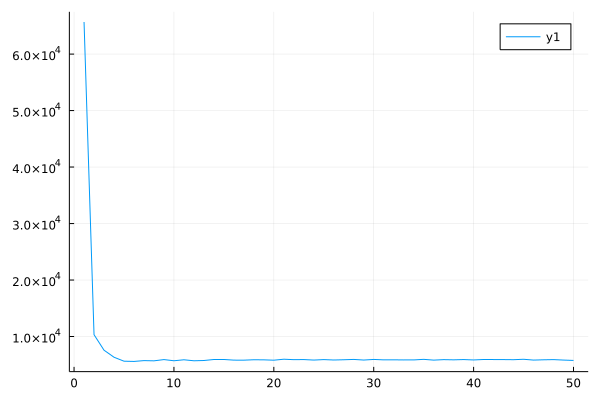

In [719]:
plot(fe_)

In [720]:
mean.(h_)

800-element Vector{Vector{Float64}}:
 [-2.57018086204697, -3.8793886780345965]
 [-0.1939073093111033, -2.6117653124085503]
 [1.79811259671539, -0.24139661952765334]
 [4.778728721183831, 1.7759584866933102]
 [4.644854765586273, 4.778221174213581]
 [-0.6650000535509326, 4.644093932997927]
 [-1.3821797258859492, -0.6664324277950923]
 [-2.466289968988515, -1.3823559883287806]
 [2.9903875175044363, -2.4638833924173564]
 [2.8468378863158614, 2.99181204600822]
 [5.6531574657462045, 2.8483677881930625]
 [0.11435484591267847, 5.653608150754179]
 [-1.368642343359262, 0.11468444384349982]
 ⋮
 [3.3621350164446753, 1.7609375749665317]
 [5.201947119608145, 3.3625940434336257]
 [0.6314000300672173, 5.201136338897687]
 [-1.6086930054863602, 0.6315097205246613]
 [-2.0101286136726357, -1.596578845776486]
 [-0.2355021441401601, -2.0235799760564626]
 [2.539227509546103, -0.3027659551051587]
 [6.891227236889161, 2.5368440552914038]
 [2.204598983736087, 6.888174938819377]
 [-1.015051739955977, 2.20490742621

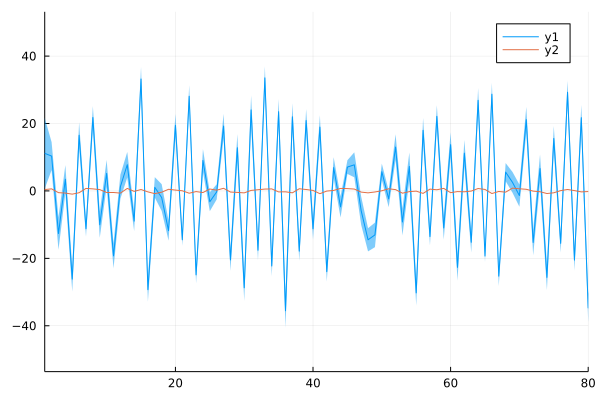

In [721]:
plot(mean.(y_out_), ribbon=sqrt.(cov.(y_out_)))
plot!(Y_train, xlims=(1, 80))

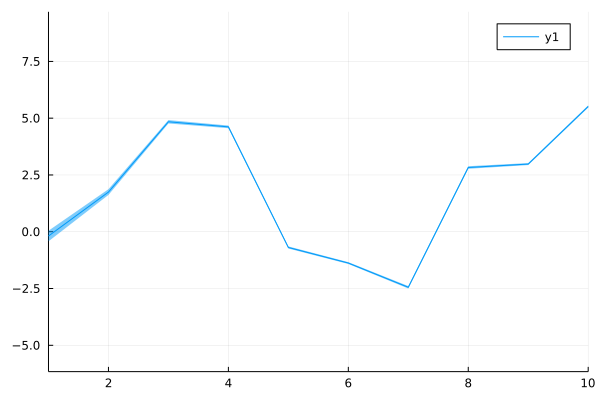

In [728]:
plot(mean.(e_), ribbon=sqrt.(cov.(e_)))

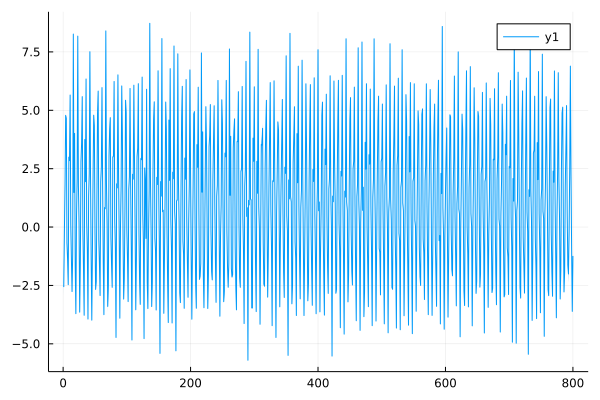

In [723]:
plot(first.(mean.(h_)), ribbon=sqrt.(first.(cov.(h_))))

In [724]:
first.(mean.(h_))

800-element Vector{Float64}:
 -2.57018086204697
 -0.1939073093111033
  1.79811259671539
  4.778728721183831
  4.644854765586273
 -0.6650000535509326
 -1.3821797258859492
 -2.466289968988515
  2.9903875175044363
  2.8468378863158614
  5.6531574657462045
  0.11435484591267847
 -1.368642343359262
  ⋮
  3.3621350164446753
  5.201947119608145
  0.6314000300672173
 -1.6086930054863602
 -2.0101286136726357
 -0.2355021441401601
  2.539227509546103
  6.891227236889161
  2.204598983736087
 -1.015051739955977
 -3.611149402734427
 -1.2369088501810226

In [725]:
mean.(e_)

800-element Vector{Float64}:
 -0.1891156271738458
  1.7464673869719012
  4.841765399690954
  4.617868627910217
 -0.6927549342651437
 -1.3795264062880526
 -2.446766211948586
  2.8281785290824333
  2.979178725361388
  5.515073556356214
  0.23822863095815525
 -1.4496948616001462
 -2.753217245624862
  ⋮
  5.316845554948607
  0.6101697014844275
 -1.6623902235388914
 -3.6339227972907486
  0.9277628815076646
  2.0772190967583914
  7.245323497125684
  2.087692811428615
 -0.9567236700745826
 -3.6415604619823667
 -1.2076972443820515
 -0.14863273268859814